In [1]:
from cvxpy.problems.problem import Cache
import numpy as np
from numba import njit, prange, vectorize
import timeit as timeit

import cvxpy as cp
import copy as copy

# %matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm
import string

from scipy.optimize import nnls
import scipy.sparse as sp

import create_grid_toy as grid

import pickle

In [2]:
x_0 = np.array([0.,0.])
T = 1
eps = 1.

FIG = False

<Figure size 432x288 with 0 Axes>

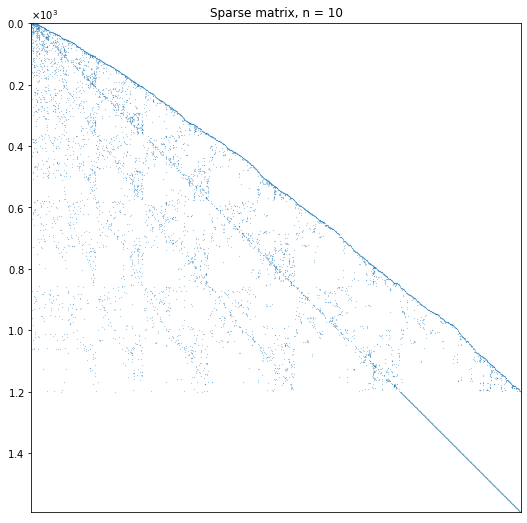

<Figure size 432x288 with 0 Axes>

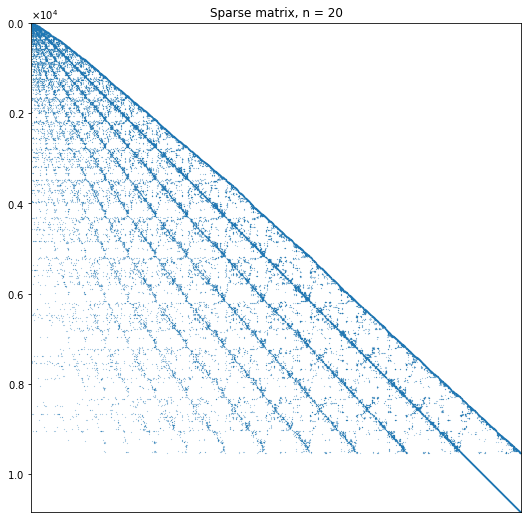

<Figure size 432x288 with 0 Axes>

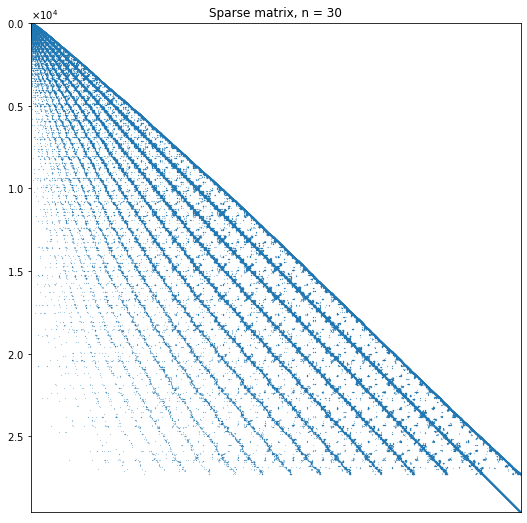

<Figure size 432x288 with 0 Axes>

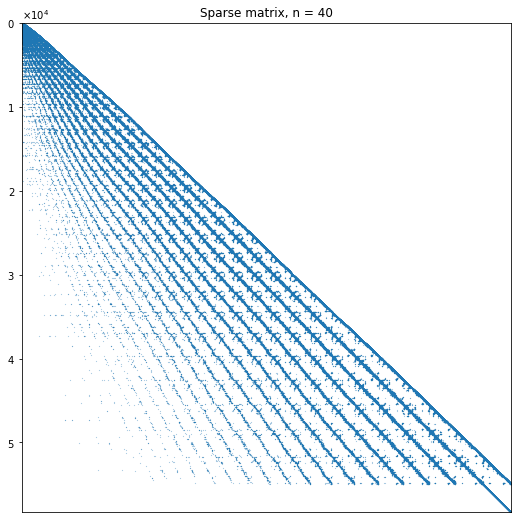

<Figure size 432x288 with 0 Axes>

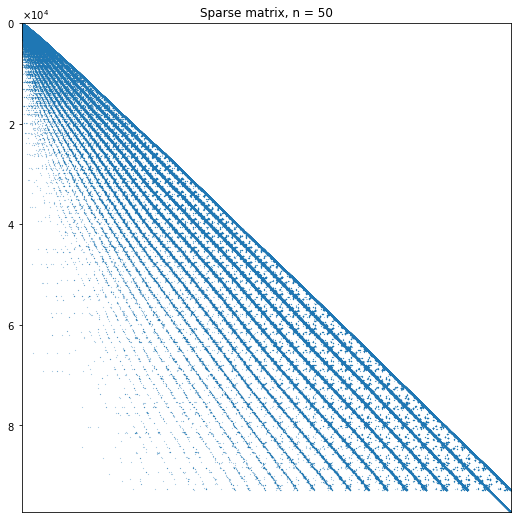

<Figure size 432x288 with 0 Axes>

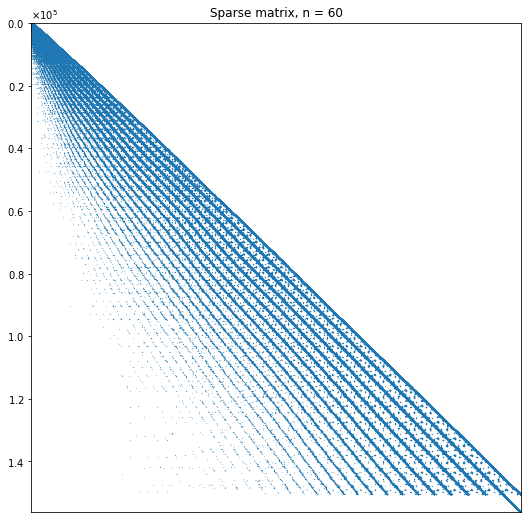

In [3]:
n = [10, 20] 
# n = [10, 20, 30, 40, 50, 60] 

for i in range(len(n)):
    name = 'Results_toy/sparse_matrix_n%i'%n[i]+'.npz'
    m = sp.load_npz(name)
    plt.figure()
    plt.figure(figsize=(16,9))
    plt.title("Sparse matrix, n = %i" %n[i])
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,2))
    plt.spy(m, markersize=0.2, alpha=0.5)
    
    plt.savefig('Results_toy/sparse_matrix_toy_n%i'%n[i]+'.pdf', bbox_inches='tight')
    plt.show()
    

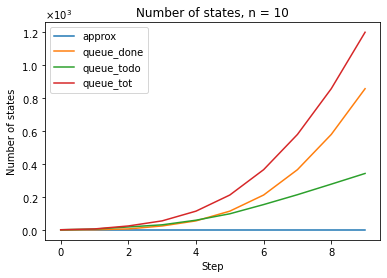

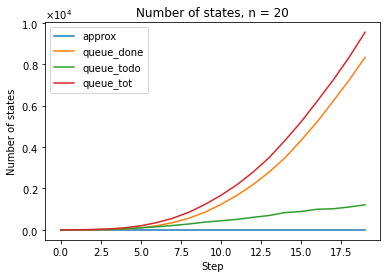

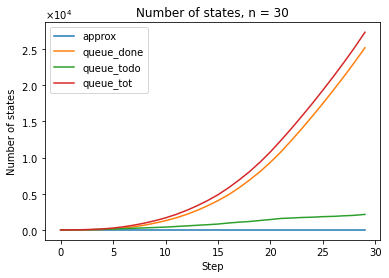

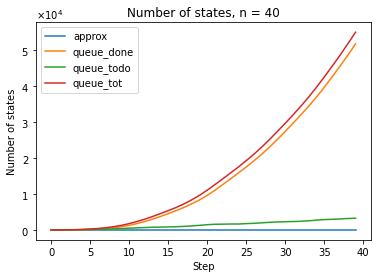

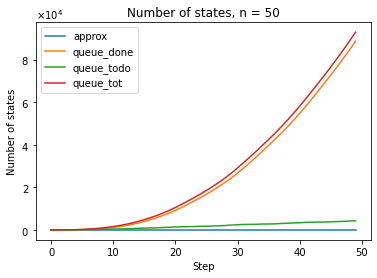

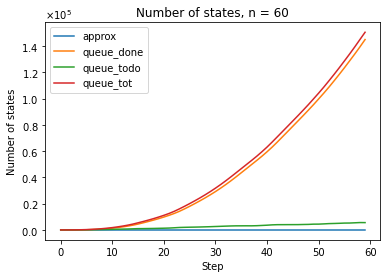

In [4]:
n = [10, 20] 
# n = [10, 20, 30, 40, 50, 60] 

# with open ('Results_from_server/results_list.txt', 'rb') as fp: results = pickle.load(fp) 

for i in range(len(n)):
    name = 'Results_toy/tree_dict_n%i'%n[i]+'.txt'
    with open (name, 'rb') as fp: results = pickle.load(fp)
    # do not consider the approx states, always 0
    idx_tmp = [True,False,True,True,True]
    nec_states = results[1][idx_tmp]
    plt.figure()
    plt.title("Number of states, n = %i" %n[i])
    lines = plt.plot(np.arange(n[i]), nec_states.T)
    plt.legend(lines[:4], ['approx', 'queue_done', 'queue_todo', 'queue_tot']) #'skipped',
    plt.xlabel('Step')
    plt.ylabel('Number of states')
    plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,3))
    plt.savefig('Results_toy/number_of_states_toy_n%i'%n[i]+'.pdf', bbox_inches='tight')
    plt.show()
    

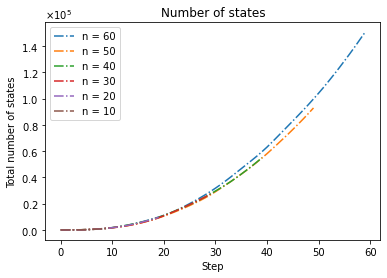

In [5]:
plt.figure()

for i in np.arange(len(n)-1,-1,-1):
    name = 'Results_toy/tree_dict_n%i'%n[i]+'.txt'
    with open (name, 'rb') as fp: results = pickle.load(fp) 
    nec_states = results[1]
    plt.plot(np.arange(n[i]), nec_states[-1], '-.', label = 'n = %i'%n[i])

    
plt.title('Number of states')
plt.xlabel('Step')
plt.ylabel('Total number of states')
plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,0))
plt.legend()
plt.savefig('Results_toy/comparison_number_of_states_toy.pdf', bbox_inches='tight')
plt.show()

In [6]:
name = 'Results_toy/MC_1000.npy'
with open(name, 'rb') as f: X = np.load(f)
prob_X = np.ones(len(X))/len(X)

In [7]:
first_m = lambda x: x
second_m = lambda x: np.array([i.reshape(-1,1)@i.reshape(1,-1) for i in x])
p_v_greater = lambda x: np.array(x[:,1]>x_0[1],dtype=int).reshape(-1,1)

first_m_X = first_m(X).T @ prob_X
second_m_X = second_m(X).T @ prob_X
variance_X = second_m_X - first_m_X[:,np.newaxis] @ first_m_X[:,np.newaxis].T
p_v_greater_X = p_v_greater(X).T @ prob_X

In [8]:
first_m_tree = np.zeros((len(n), 2))
second_m_tree = np.zeros((len(n), 2, 2))
variance_tree = np.zeros((len(n), 2, 2))
p_v_greater_tree = np.zeros(len(n))

for i in range(len(n)):
    name = 'Results_toy/matrix_keys_n%i'%n[i]+'.txt'
    with open(name, 'rb') as fp: keys_dict, key_arr = pickle.load(fp)
    name = 'Results_toy/probs_n%i'%n[i]+'.npy'
    with open(name, 'rb') as f: prob = np.load(f)

    first_m_tree[i] = first_m(key_arr).T @ prob
    second_m_tree[i] = second_m(key_arr).T @ prob
    variance_tree[i] = second_m_tree[i] - first_m_tree[i][:,np.newaxis] @ first_m_tree[i][:,np.newaxis].T
    p_v_greater_tree[i] = p_v_greater(key_arr).T @ prob

second_m_X = second_m_X.reshape(4)[[0,1,3]]
variance_X = variance_X.reshape(4)[[0,1,3]]
second_m_tree = second_m_tree.reshape(len(n),4)[:,[0,1,3]]
variance_tree = variance_tree.reshape(len(n),4)[:,[0,1,3]]

err_rel_firt_m = np.abs((first_m_tree-first_m_X)/first_m_tree)*100
err_rel_second_m = np.abs((second_m_tree-second_m_X)/second_m_tree)*100
err_rel_variance = np.abs((variance_tree-variance_X)/variance_tree)*100
err_rel_p_v = np.abs((p_v_greater_tree-p_v_greater_X )/p_v_greater_tree)*100

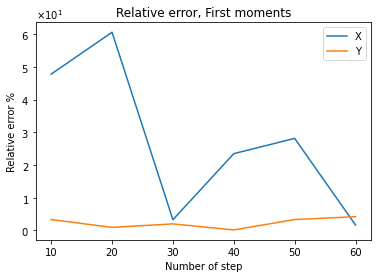

array([1.63397094, 0.14479899])

In [10]:
plt.figure()
plt.plot(n, err_rel_firt_m)
plt.title('Relative error, First moments')
plt.xlabel('Number of step')
plt.ylabel('Relative error %')
plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,0))
plt.legend(['X', 'Y'])
plt.savefig('Results_toy/Rel_err_mom1_toy.pdf', bbox_inches='tight')
plt.show()

np.min(err_rel_firt_m,0)

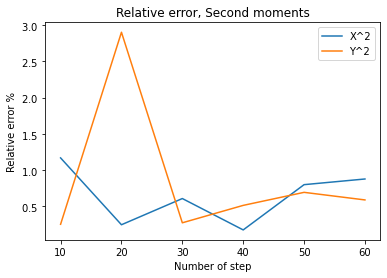

In [11]:
plt.figure()
plt.plot(n, err_rel_second_m[:,[0,2]])
plt.title('Relative error, Second moments')
plt.xlabel('Number of step')
plt.ylabel('Relative error %')
plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,0))
plt.legend(['X^2', 'Y^2'])
plt.savefig('Results_toy/Rel_err_mom2_toy.pdf', bbox_inches='tight')
plt.show()

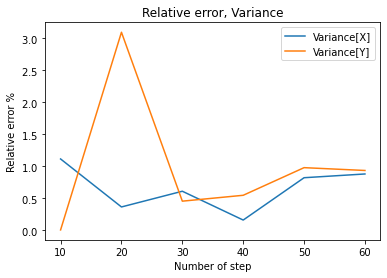

array([1.55960787e-01, 1.15970558e+02, 1.80919947e-03])

In [12]:
plt.figure()
plt.plot(n, err_rel_variance[:,[0,2]])
plt.title('Relative error, Variance')
plt.xlabel('Number of step')
plt.ylabel('Relative error %')
plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,0))
plt.legend(['Variance[X]', 'Variance[Y]'])
plt.savefig('Results_toy/Rel_err_variance_toy.pdf', bbox_inches='tight')
plt.show()

np.min(err_rel_variance,0)

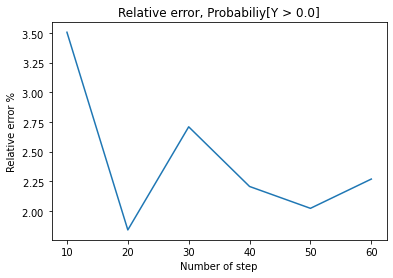

1.8408233140671106

In [13]:
plt.figure()
plt.plot(n, err_rel_p_v)
plt.title('Relative error, Probability[Y > %3.1f]'%x_0[1])
plt.xlabel('Number of step')
plt.ylabel('Relative error %')
plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,0))
plt.savefig('Results_toy/Rel_err_prob_variance_toy.pdf', bbox_inches='tight')
plt.show()

np.min(err_rel_p_v)